In [1]:
import pandas as pd
import joblib
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import eval
from helpers.preprocessing import read_all_data
from mlp_architecture import MLPDataset, MLPModel
import yaml
from torch.utils.data import DataLoader
from helpers import TrainingLoop

In [2]:

# y = pd.read_csv('test_data/subject_009_01__y.csv')

In [3]:
device = torch.device('cpu')

# Load initial model
with open('../c2_final_models/initial_hyperparams.yaml') as f:
    initial_hyperparams = yaml.load(f, Loader=yaml.SafeLoader)
initial_model = eval.load_model('../c2_final_models/initial2.torch', MLPModel(initial_hyperparams))

# Load tuned model
with open('../c2_final_models/tuned_hyperparams.yaml') as f:
    tuned_hyperparams = yaml.load(f, Loader=yaml.SafeLoader)
tuned_model = eval.load_model('../c2_final_models/tuned2.torch', MLPModel(tuned_hyperparams))

# Load tuned model w/ early stopping
with open('../c2_final_models/tuned_hyperparams.yaml') as f:
    tuned2_hyperparams = yaml.load(f, Loader=yaml.SafeLoader)
tuned2_model = eval.load_model('../c2_final_models/tuned3.torch', MLPModel(tuned_hyperparams))

In [4]:
import os
if os.getcwd().split('/')[-1] == 'MLP':
    os.chdir('..')

data_dict = read_all_data()
imu = data_dict['imu'].to_numpy()
ann = data_dict['ann'].to_numpy().flatten()
del data_dict # Remove to free memory

initial_tl = TrainingLoop(MLPModel, MLPDataset, initial_hyperparams, imu, ann, device, 'initial2')
tuned_tl = TrainingLoop(MLPModel, MLPDataset, tuned_hyperparams, imu, ann, device, 'tuned2')
tuned2_tl = TrainingLoop(MLPModel, MLPDataset, tuned_hyperparams, imu, ann, device, 'tuned3')

Using device: cpu
Using device: cpu
Using device: cpu


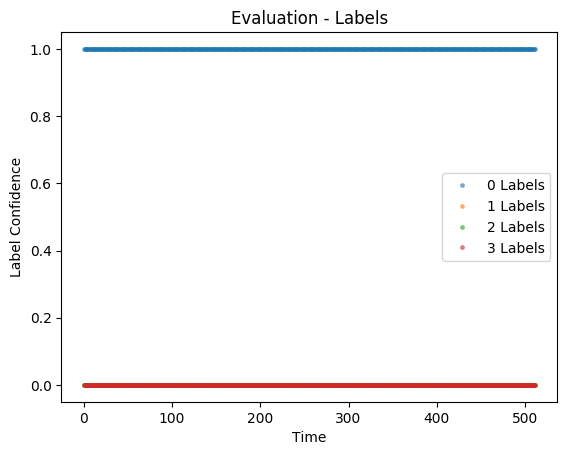

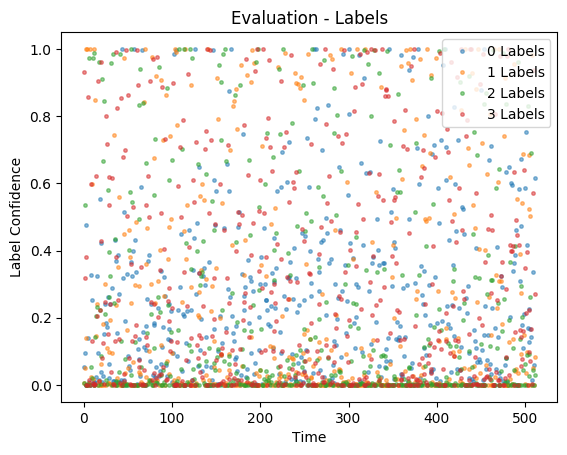

[[0.054725296795368195,
  0.09473572671413422,
  2.312037540586065e-11,
  0.476807177066803,
  1.1724659998435527e-07,
  0.13921698927879333,
  0.008183589205145836,
  0.0009960898896679282,
  0.32686635851860046,
  0.25127744674682617,
  0.005327514372766018,
  3.329143964947434e-06,
  0.008456301875412464,
  0.008242584764957428,
  0.025000207126140594,
  0.3228219449520111,
  0.09562809765338898,
  0.015446508303284645,
  0.5543159246444702,
  0.4219449758529663,
  0.03844292089343071,
  0.009722274728119373,
  0.026873653754591942,
  0.15218493342399597,
  0.24151532351970673,
  0.18463122844696045,
  0.17347858846187592,
  0.26248711347579956,
  0.06291992217302322,
  0.02026195265352726,
  0.24198609590530396,
  0.0029771788977086544,
  0.2891744375228882,
  0.011169525794684887,
  0.01112959161400795,
  0.4322558343410492,
  0.008995113894343376,
  0.3692426085472107,
  0.1556873917579651,
  0.38652825355529785,
  0.2691219449043274,
  0.0082219447940588,
  0.014614093117415905,

In [5]:
eval.evaluate_first_batch(initial_model, initial_tl.val_generator, plot=True)
eval.evaluate_first_batch(tuned_model, tuned_tl.val_generator, plot=True)
# eval.evaluate(tuned2_model, tuned2_tl.val_generator, plot=True)

In [6]:
from torch import nn
import torchmetrics as tm

def model_output_to_classes(model_output:torch.Tensor) -> torch.Tensor:
    return torch.max(model_output, 1)[1] # Indices of max values

def stats(model:nn.Module, dataloader:torch.utils.data.DataLoader, num_classes) -> float:
    
    precision = tm.Precision(task="multiclass", average='macro', num_classes=num_classes)
    recall = tm.Recall(task="multiclass", average='macro', num_classes=num_classes)
    f_one = tm.F1Score(task="multiclass", num_classes=num_classes)

    accs = []
    precisions = []
    recalls = []
    f_ones = []
    f_ones1 = []
    f_ones2 = []
    f_ones3 = []
    f_ones4 = []
    for (X, y) in tqdm(dataloader):
        model.eval()
        with torch.no_grad():
            y_p = model_output_to_classes(model(X))
            accs.append((y_p == y).sum().item()/len(y))
            recalls.append((recall(y_p,y)).item())
            precisions.append((precision(y_p,y)).item())
            f_ones.append((f_one(y_p,y)).item())
            oney = y.clone()
            oneyp = y_p.clone()
            oney[oney!=0] = -1
            oneyp[oneyp!=0] = -1

            twoy = y.clone()
            twoyp = y_p.clone()
            twoy[twoy!=1] = -1
            twoyp[twoyp!=1] = -1

            threey = y.clone()
            threeyp = y_p.clone()
            threey[threey!=2] = -1
            threeyp[threeyp!=2] = -1

            foury = y.clone()
            fouryp = y_p.clone()
            foury[foury!=3] = -1
            fouryp[fouryp!=3] = -1

            f_ones1.append((f_one(oneyp,oney)).item())
            f_ones2.append((f_one(twoyp,twoy)).item())
            f_ones3.append((f_one(threeyp,threey)).item())
            f_ones4.append((f_one(fouryp,foury)).item())
    return sum(accs)/len(accs), sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f_ones)/len(f_ones), sum(f_ones1)/len(f_ones1),sum(f_ones2)/len(f_ones2),sum(f_ones3)/len(f_ones3),sum(f_ones4)/len(f_ones4)

initial_stats = stats(initial_model, initial_tl.train_generator, num_classes=initial_hyperparams['num_classes'])
tuned_stats = stats(tuned_model, tuned_tl.train_generator, num_classes=tuned_hyperparams['num_classes'])
tuned2_stats = stats(tuned2_model, tuned2_tl.train_generator, num_classes=tuned2_hyperparams['num_classes'])
print(initial_stats)
print(tuned_stats)
# print(tuned2_stats)

100%|██████████| 2097/2097 [00:15<00:00, 131.90it/s]

(0.7504276216313666, 0.18760690540714836, 0.25, 0.7504276216285934, 0.7504276216285934, 0.9587592284737397, 0.9456861237144834, 0.8459822694119465)
(0.2852565675267804, 0.307433446177313, 0.3951270459774965, 0.28525656753059336, 0.38740593413824576, 0.7657522369579411, 0.7432783622371053, 0.6740766016994707)


In [7]:
from helpers.preprocessing import normalize_data

def read_test_data(path):
    arr = pd.read_csv(path, names=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']).to_numpy()
    return normalize_data(arr, method='standard')[0]
    

In [8]:
import os
if os.getcwd().split('/')[-1] == 'MLP':
    os.chdir('..')
    
x = read_test_data('test_data/subject_009_01__x.csv')

In [9]:
import numpy as np
def nearest_neighbors_downsample(y_time, x_time):
    out = []
    for y_t in y_time:
        diff = np.absolute(x_time - y_t)
        index = diff.argmin()
        out.append(ann[index])
    return out

In [10]:
scaler = joblib.load('c2_final_models/tuned2_scaler.joblib')
scaled_x = scaler.transform(x)
scaled_x

for i in ['009', '010', '011', '012']:
    ytest_p = initial_model(torch.tensor(x, dtype=torch.float32))
    out = TrainingLoop.model_output_to_classes(ytest_p)
    print(out)

    y_t = pd.read_csv(f'test_data/subject_{i}_01__y_time.csv', names=['time'])
    x_t = pd.read_csv(f'test_data/subject_{i}_01__x_time.csv', names=['time'])

    y = nearest_neighbors_downsample(y_t.to_numpy().flatten(), x_t.to_numpy().flatten())
    
    print(sum(y)/len(y))

    np.savetxt(f'predictions/subject_{i}_01__y.csv', y, delimiter=',')

tensor([0, 0, 0,  ..., 0, 0, 0])
0.4717835333754475
tensor([0, 0, 0,  ..., 0, 0, 0])
0.44881825590872043
tensor([0, 0, 0,  ..., 0, 0, 0])
0.47017001545595055
tensor([0, 0, 0,  ..., 0, 0, 0])
0.4346866725507502


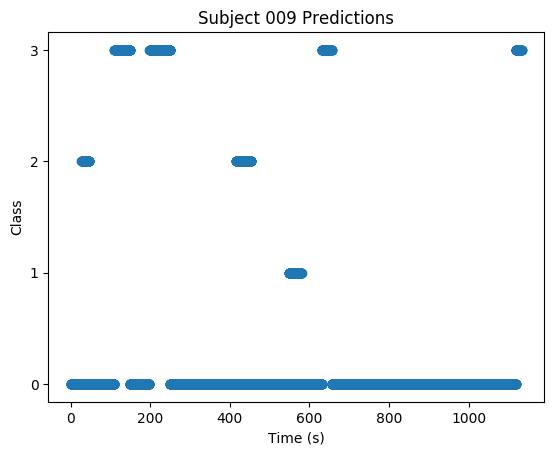

In [11]:
import importlib
import matplotlib.pyplot as plt
importlib.reload(plt)
plt.figure()
plt.scatter(y_t['time'], y)
plt.yticks(range(4))
plt.xlabel('Time (s)')
plt.ylabel('Class')
plt.title('Subject 009 Predictions')
plt.show()